In [1]:
#!usr/bin/python
########################################################################
########################################################################
########################################################################

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

from scipy.integrate import trapz

In [5]:
########################################################################
########################################################################

minlon,maxlon,minlat,maxlat=[-65.,30.,-60.,0.]

########################################################################
########################################################################

pname='Data/'
fname='EN421.interp.UV.ref2000.200801_200812.nc'

nc=Dataset(pname+fname)
lat=nc.variables['lat'][:];ilat,=np.where((lat>=minlat)&(lat<=maxlat))
lon=nc.variables['lon'][:];ilon,=np.where((lon>=minlon)&(lon<=maxlon))
lon=lon[ilon[0]:ilon[-1]+1];lat=lat[ilat[0]:ilat[-1]+1]

z=nc.variables['z'][:]
u=nc.variables['u'][:,:,ilat[0]:ilat[-1]+1,ilon[0]:ilon[-1]+1]
v=nc.variables['v'][:,:,ilat[0]:ilat[-1]+1,ilon[0]:ilon[-1]+1]
nc.close()

########################################################################
########################################################################
########################################################################
########################################################################
########################################################################

#######################################################
#Get distance from lon-lat grid
#######################################################

def lonlat_to_m(lon,lat):
    lon = lon*2*np.pi/360.
    lat = lat*2*np.pi/360.
    if len(lat.shape)==2:
        dx = np.arccos(np.sin(lat[1:,:])*np.sin(lat[:-1,:]) + np.cos(lat[1:,:])*np.cos(lat[:-1,:])*np.cos(lon[1:,:]-lon[:-1,:]))*6371000.
        dy = np.arccos(np.sin(lat[:,1:])*np.sin(lat[:,:-1]) + np.cos(lat[:,1:])*np.cos(lat[:,:-1])*np.cos(lon[:,1:]-lon[:,:-1]))*6371000.
    else:
        dx = np.arccos(np.sin(lat[1:])*np.sin(lat[:-1]) + np.cos(lat[1:])*np.cos(lat[:-1])*np.cos(lon[1:]-lon[:-1]))*6371000.
        dy = np.arccos(np.sin(lat[1:])*np.sin(lat[:-1]) + np.cos(lat[1:])*np.cos(lat[:-1])*np.cos(lon[1:]-lon[:-1]))*6371000.        
    return dx,dy

#######################################################

lon_u = np.zeros(len(lon)+1)
lon_u[1:-1] = (lon[1:] + lon[:-1])/2
lon_u[0] = lon[0] - (lon[1]-lon[0])/2; lon_u[-1] = lon[-1] + (lon[-1]-lon[-2])/2

lat_v = np.zeros(len(lat)+1)
lat_v[1:-1] = (lat[1:] + lat[:-1])/2
lat_v[0] = lat[0] - (lat[1]-lat[0])/2; lat_v[-1] = lat[-1] + (lat[-1]-lat[-2])/2

lon2d,lat2d = np.meshgrid(lon,lat)

dx,dy = lonlat_to_m(lon2d.T,lat2d.T)
dx,dy = dx.T,dy.T


lon2d,lat2d = np.meshgrid(lon,lat_v)

dx_v ,dy_v = lonlat_to_m(lon2d.T,lat2d.T)
dx_v ,dy_v = dx_v.T,dy_v.T


lon2d,lat2d = np.meshgrid(lon_u,lat)

dx_u ,dy_u = lonlat_to_m(lon2d.T,lat2d.T)
dx_u ,dy_u = dx_u.T,dy_u.T


#######################################################


def barotropic_psi_original(uu,z,lim):
    """
    barotropic_psi: 
    (1) Vertical integrated zonal transport (from 2000 m to 0m)
    (2) Meridionally integrated (1), from pole to equator
    """
    ux=np.cumsum(uu[:lim],axis=0)/np.gradient(z[:lim])[:,np.newaxis,np.newaxis]         # vertical integration
    ux=np.ma.masked_equal(ux,0)
    uz=np.nancumsum(ux[:,:,:],axis=1)/np.gradient(lat[:])[np.newaxis,:,np.newaxis]        # meridional integration
    psi=np.ma.masked_equal(uz,0)
    
    return psi                                                                            # psi[0]: surface


def barotropic_psi_v1(uu,z,lim):
    """
    barotropic_psi: 
    (1) Vertical integrated zonal transport (from 2000 m to 0m)
    (2) Meridionally integrated (1), from pole to equator
    """
    
    uz = trapz(uu[:lim,:,:],z[:lim],axis=0)         # vertical integration
    np.ma.set_fill_value(uz, 0); uz.mask=False
    psi = -np.cumsum(uz * dy_v,axis=0)   # meridional integration
    
    return psi      

def barotropic_psi_v2(uu,vv,z,lim):
            
        
    uz = trapz(uu[:lim,:,:],z[:lim],axis=0) * dy_v
    vz = trapz(vv[:lim,:,:],z[:lim],axis=0) * dx_u
    
    np.ma.set_fill_value(uz, 0); uz.mask=False
    np.ma.set_fill_value(vz, 0); vz.mask=False

    
    print(uz.shape,dy.shape)
    uz = (uz[:,1:]+uz[:,:-1])/2
    vz = (vz[1:,:]+vz[:-1,:])/2 
    
    psi = np.zeros((len(lat)-1,len(lon)-1))*np.nan
    psi[:,0] = -1*np.cumsum(uz[:-1,0])
    psi[0,:] = np.cumsum(vz[0,:-1])

    for i in range(1,len(lon)-1):
        for j in range(1,len(lat)-1):
            psi[j,i]= psi[j-1,i-1] + (vz[j-1,i] - uz[j,i])
            
    return psi   



<ipython-input-5-81b1ff843a28>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat=nc.variables['lat'][:];ilat,=np.where((lat>=minlat)&(lat<=maxlat))
<ipython-input-5-81b1ff843a28>:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon=nc.variables['lon'][:];ilon,=np.where((lon>=minlon)&(lon<=maxlon))
<ipython-input-5-81b1ff843a28>:17: Deprecation

<ipython-input-22-298e92c1931e>:12: RuntimeWarning: Mean of empty slice
  psi=barotropic_psi_original(np.nanmean(u,axis=0),z,klim)[-1,:,:]*-1;
<ipython-input-22-298e92c1931e>:17: RuntimeWarning: Mean of empty slice
  psi = barotropic_psi_v1(np.nanmean(u,axis=0),z,klim)


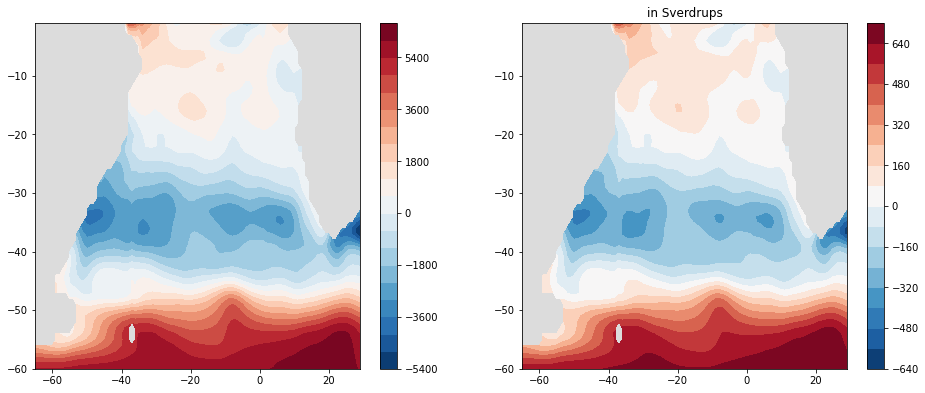

In [22]:
klim = np.min(np.where(z>2000))

mask = u[0,0,:,:] * np.nan
mask[np.isfinite(u[0,0,:,:])] = 1

for imonth in [0]:

    ####
    fig = plt.figure(figsize=(16.0,14.0)) 
    
    ax1 = fig.add_subplot(221,facecolor='Gainsboro')  
    psi=barotropic_psi_original(np.nanmean(u,axis=0),z,klim)[-1,:,:]*-1; 
    plt.contourf(lon,lat,psi-psi[-20,-20],20,cmap='RdBu_r')
    plt.colorbar()
    
    ax2 = fig.add_subplot(222,facecolor='Gainsboro')  
    psi = barotropic_psi_v1(np.nanmean(u,axis=0),z,klim)
    plt.contourf(lon,lat,(psi-psi[-20,-20])* 1e-6 *mask,20,cmap='RdBu_r')
    plt.title('in Sverdrups')
    plt.colorbar()
    
    '''
    ax3 = fig.add_subplot(223,facecolor='Gainsboro')  
    psi = barotropic_psi_v2(u[imonth],v[imonth],z,klim) * 1e-6
    plt.contourf(lon_u[1:-1],lat_v[1:-1],psi,10,cmap='RdBu_r')
    plt.title('in Sverdrups')
    plt.colorbar()

    ax3 = fig.add_subplot(223,facecolor='Gainsboro')  
    plt.pcolormesh(lon,lat,-np.diff(psi,axis=0)/np.mean(dy)/2000,vmin=-1,vmax=1)
    plt.colorbar()

    ax4 = fig.add_subplot(224,facecolor='Gainsboro')  
    plt.pcolormesh(lon,lat,np.sum(u[imonth],axis=0)/2000,vmin=-1,vmax=1)
    plt.colorbar()'''




########################################################################


In [20]:
'''argoname = '/Users/gula/Desktop/Work/Latex/Articles/Published/16_RenaultMolemakerGulaMassonMcWilliams/Figures/make_some_figures/psi_baro_34B_NA_ubvb.mat'

import scipy.io
lon_argo = scipy.io.loadmat(argoname)['lon_p']
lat_argo = scipy.io.loadmat(argoname)['lat_p']
lon_argo,lat_argo = np.meshgrid(lon_argo,lat_argo)

psi_argo = scipy.io.loadmat(argoname)['psim']*1e-6

########


fig = plt.figure(figsize=(16.0,14.0)) 

ax1 = fig.add_subplot(221,facecolor='Gainsboro')  
plt.contourf(psi_argo,10,cmap='RdBu_r')
plt.colorbar()

ax2 = fig.add_subplot(222,facecolor='Gainsboro')  
plt.contourf(lon,lat,psi,10,cmap='RdBu_r')
plt.title('in Sverdrups')
plt.colorbar()
'''


"argoname = '/Users/gula/Desktop/Work/Latex/Articles/Published/16_RenaultMolemakerGulaMassonMcWilliams/Figures/make_some_figures/psi_baro_34B_NA_ubvb.mat'\n\nimport scipy.io\nlon_argo = scipy.io.loadmat(argoname)['lon_p']\nlat_argo = scipy.io.loadmat(argoname)['lat_p']\nlon_argo,lat_argo = np.meshgrid(lon_argo,lat_argo)\n\npsi_argo = scipy.io.loadmat(argoname)['psim']*1e-6\n\n########\n\n\nfig = plt.figure(figsize=(16.0,14.0)) \n\nax1 = fig.add_subplot(221,facecolor='Gainsboro')  \nplt.contourf(psi_argo,10,cmap='RdBu_r')\nplt.colorbar()\n\nax2 = fig.add_subplot(222,facecolor='Gainsboro')  \nplt.contourf(lon,lat,psi,10,cmap='RdBu_r')\nplt.title('in Sverdrups')\nplt.colorbar()\n"